In [1]:
import numpy as np
import nibabel as nib
from nilearn import plotting
from src.connectivity_functions import *
from src.tree_functions import *
from src.ni_functions import *
from src.io_functions import load_data
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
project_path = "/workspaces/bha2"
conn_size = 2165

In [3]:

optimal_parcellation = nib.load(
    os.path.join(
        project_path,
        "data",
        "processed",
        "n" + str(conn_size),
        "optimal_parcellation.nii.gz",
    )
).get_fdata()
module_sizes = nib.load(
    os.path.join(
        project_path, "data", "processed", "n" + str(conn_size), "module_sizes.nii.gz"
    )
).get_fdata()
module_idx = np.setdiff1d(np.unique(optimal_parcellation), [0]).astype(int)

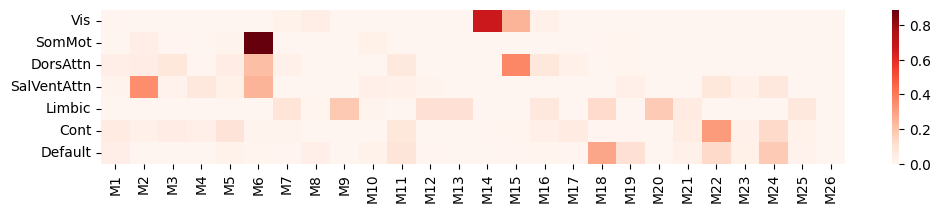

In [16]:
rsn = nib.load(
    os.path.join(project_path, "brain_templates", "atlases", "Yeo7_networks.nii.gz")
)
rsn_vol = rsn.get_fdata()
rsn_vol_masked = rsn_vol * np.where(optimal_parcellation > 0, 1, 0)

rsn_labels = np.loadtxt(
    os.path.join(project_path, "brain_templates", "atlases", "Yeo7_networks.txt"),
    dtype=str,
)


RSN_table = pd.DataFrame(
    columns=rsn_labels,
    index=np.array(["M" + str(i) for i in module_idx]),
    dtype=float,
)

for idx in module_idx:
    module_vol = optimal_parcellation == idx
    m_size = np.setdiff1d(np.unique(module_sizes[module_vol]), [0])

    if m_size > 5:
        rsn_count = np.zeros((int(rsn_vol_masked.max())))
        for i in range(1, int(rsn_vol_masked.max()) + 1):
            rsn_mask = np.where(rsn_vol_masked == i, 1, 0)
            rsn_count[i - 1] = (rsn_mask * module_vol).sum() / (rsn_mask.sum())
        RSN_table.loc["M" + str(idx)] = rsn_count

fig = plt.figure(figsize=(12,2))
sns.heatmap(pd.DataFrame.transpose(RSN_table), cmap="Reds", cbar=True)
plt.savefig(
    os.path.join(
        project_path,
        "data",
        "figures",
        "optimal_parcellation_RSNs.svg",
    ),
    dpi=300,
    bbox_inches="tight",
    format="svg",
)

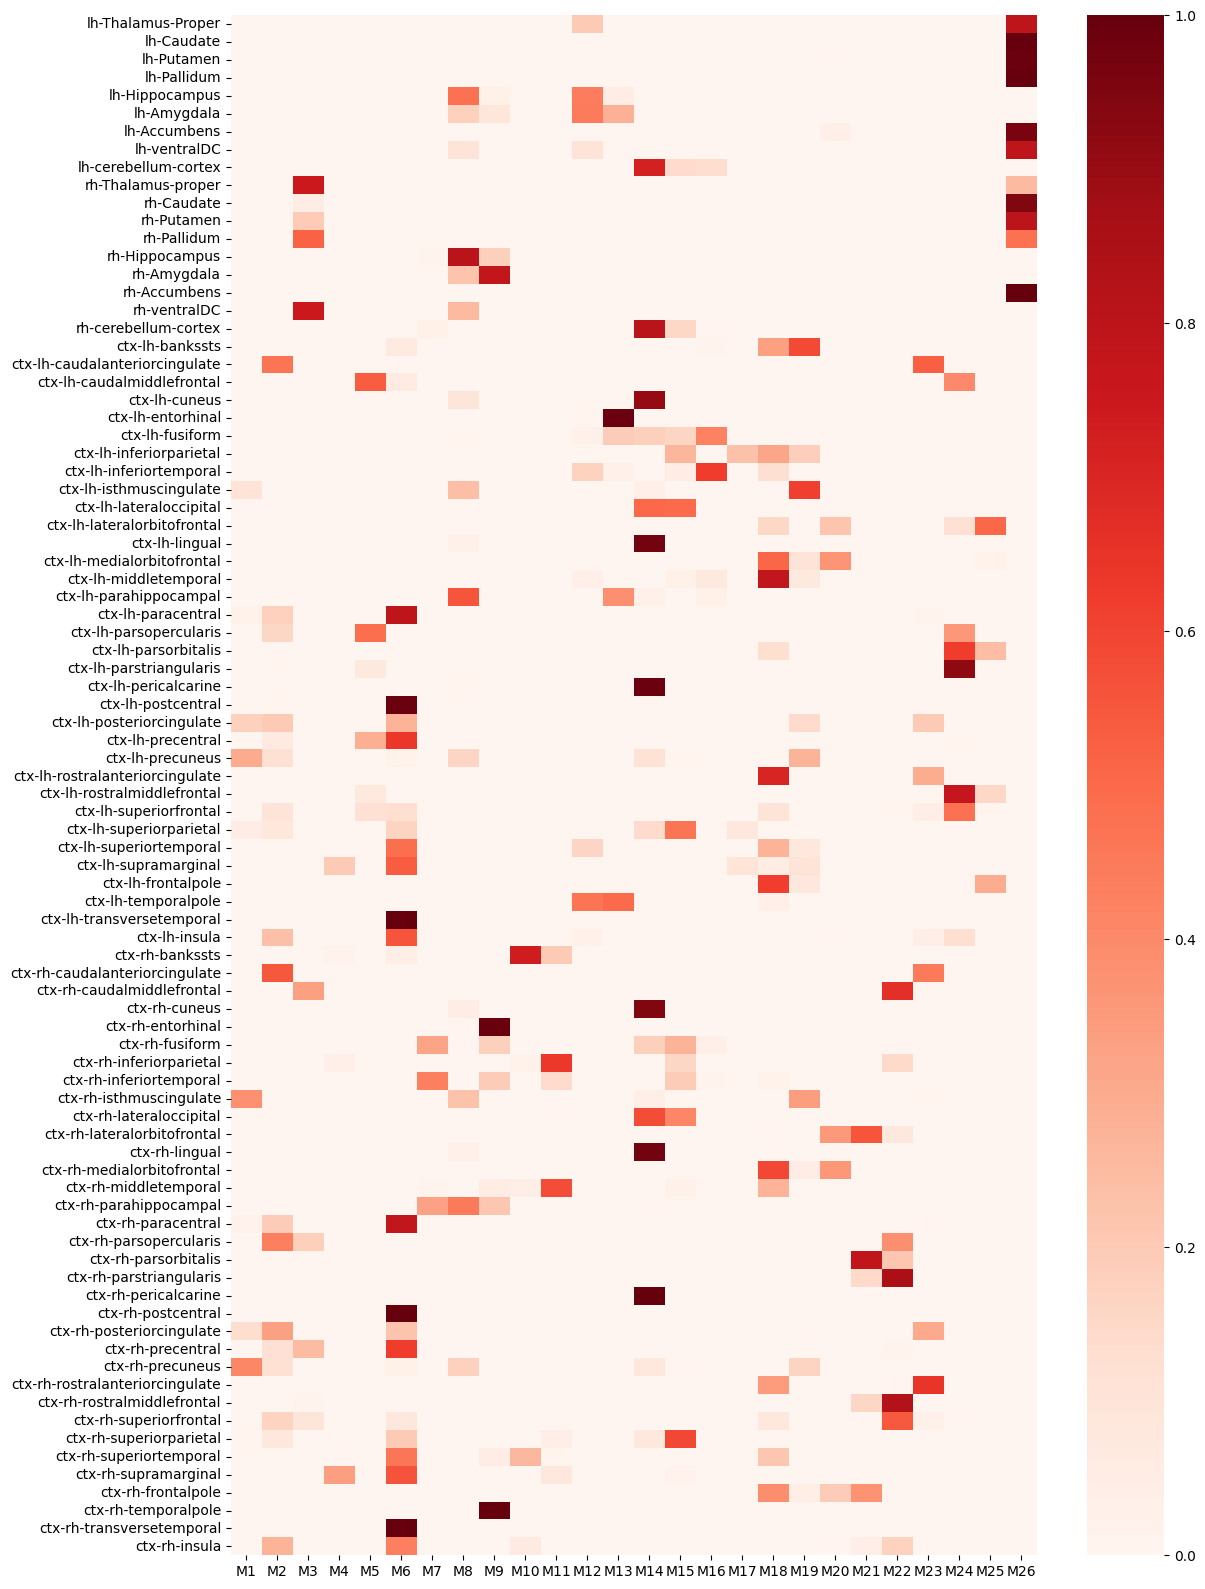

In [17]:
desikan = nib.load(
    os.path.join(project_path, "brain_templates", "atlases", "Desikan-killiany.nii.gz")
)
desikan_vol = desikan.get_fdata()
desikan_vol_masked = desikan_vol * np.where(optimal_parcellation > 0, 1, 0)

desikan_labels = np.loadtxt(
    os.path.join(project_path, "brain_templates", "atlases", "Desikan-killiany.txt"),
    dtype=str,
)


desikan_table = pd.DataFrame(
    columns=desikan_labels,
    index=np.array(["M" + str(i) for i in module_idx]),
    dtype=float,
)

for idx in module_idx:
    module_vol = optimal_parcellation == idx
    m_size = np.setdiff1d(np.unique(module_sizes[module_vol]), [0])
    
    if m_size > 5:
        desikan_count = np.zeros((int(desikan_vol_masked.max())))
        for i in range(1, int(desikan_vol_masked.max()) + 1):
            desikan_mask = np.where(desikan_vol_masked == i, 1, 0)
            desikan_count[i - 1] = (desikan_mask * module_vol).sum() / (
                desikan_mask.sum()
            )
        desikan_table.loc["M" + str(idx)] = desikan_count

fig = plt.figure(figsize=(13,20))
sns.heatmap(
    pd.DataFrame.transpose(desikan_table),
    cmap="Reds",
    cbar=True,
)
plt.savefig(
    os.path.join(
        project_path,
        "data",
        "figures",
        "optimal_parcellation_anatomy.svg",
    ),
    dpi=300,
    bbox_inches="tight",
    format="svg",
)

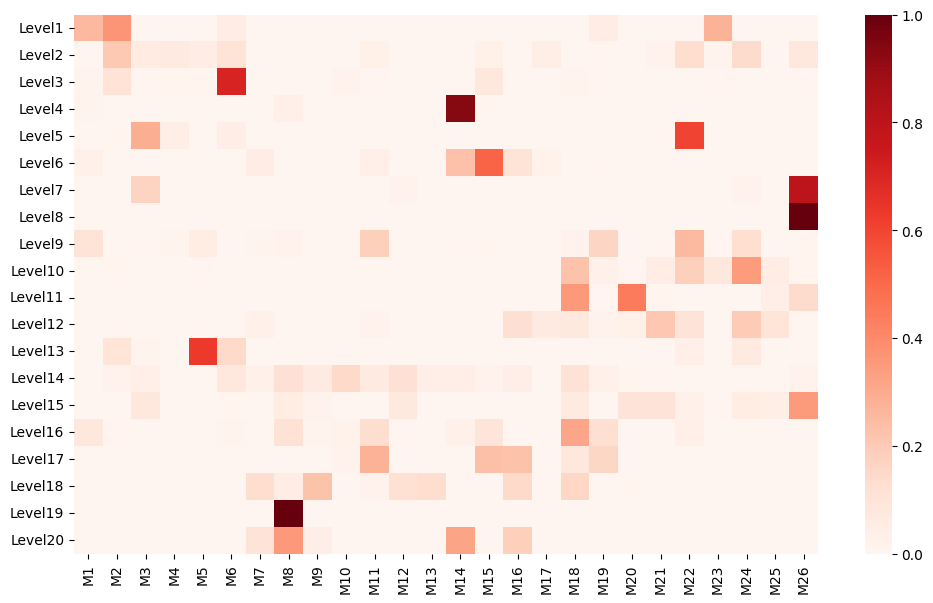

In [18]:
bha1 = nib.load(
    os.path.join(project_path, "brain_templates", "atlases", "BHA1_level20.nii.gz")
)
bha1_labels = np.loadtxt(
    os.path.join(project_path, "brain_templates", "atlases", "BHA1_level20.txt"),
    dtype=str,
)
bha1_vol = bha1.get_fdata()
bha1_vol_masked = bha1_vol * np.where(optimal_parcellation > 0, 1, 0)

bha1_table = pd.DataFrame(
    columns=bha1_labels,
    index=np.array(["M" + str(i) for i in module_idx]),
    dtype=float,
)

for idx in module_idx:
    module_vol = optimal_parcellation == idx
    m_size = np.setdiff1d(np.unique(module_sizes[module_vol]), [0])
    
    if m_size > 5:
        bha1_count = np.zeros((int(bha1_vol_masked.max())))
        for i in range(1, int(bha1_vol_masked.max()) + 1):
            bha1_mask = np.where(bha1_vol_masked == i, 1, 0)
            bha1_count[i - 1] = (bha1_mask * module_vol).sum() / (bha1_mask.sum())
        bha1_table.loc["M" + str(idx)] = bha1_count

fig = plt.figure(figsize=(12,7))
sns.heatmap(pd.DataFrame.transpose(bha1_table), cmap="Reds", cbar=True)
plt.savefig(
    os.path.join(
        project_path,
        "data",
        "figures",
        "optimal_parcellation_BHA1.svg",
    ),
    dpi=300,
    bbox_inches="tight",
    format="svg",
)